In [1]:
import os  # add MaaSSim to path (not needed if MaaSSim is already in path)
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from datetime import datetime, timezone

import pandas as pd
from pathlib import Path
from typing import Dict
import numpy as np
import seaborn as sns
from stable_baselines3 import DQN
from stable_baselines3.common.base_class import BaseAlgorithm
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

from MaaSSimGym.massim_env import MaaSSimEnv

from MaaSSimGym.gym_api_controller import Observation

Let's use DQN model with MultiInputPolicy without custom parameters tuning. We will wrap the environment into a VecEnv to enable normalization.
Offer travel time and offer wait time will be normalized. We will let model focus only on exploring the environment for 2500 steps (i.e. 2500 decisions about accepting a ride request) and run for a total number of 10000 steps

In [2]:
def test_train(env_config_path: str, model_prefix: str) -> BaseAlgorithm:
    env = DummyVecEnv([lambda: MaaSSimEnv(config_path=env_config_path)])
    env = VecNormalize(env, norm_obs=True, norm_reward=True, norm_obs_keys=[
        "offer_travel_time",
        "offer_wait_time",
    ])
    model_name = datetime.now(tz=timezone.utc).strftime(f"{model_prefix}_%Y%m%dT%H%M%S")
    model = DQN("MultiInputPolicy", env, verbose=1, tensorboard_log="dqn_maassim_tensorboard/",
                learning_starts=1000)
    model = model.learn(total_timesteps=5000)
    model.save(model_name)
    env.close()
    return model



After the model is trained, we will let it run for a couple of steps to evaluate his behaviour. We will save logs of its decision to a dataframe.

In [3]:
from typing import cast


def test_run_model(model: BaseAlgorithm, name: str) -> None:
    day = 0

    def _create_row(observation: Observation, action: np.ndarray, reward: float, decision_id: int) -> Dict[str, float]:
        return {
            'day': day,
            'decision_id': decision_id,
            'is_reposition': bool(observation['is_reposition']),
            'offer_fare': float(observation['offer_fare']),
            'offer_travel_time': float(observation['offer_travel_time']),
            'offer_wait_time': float(observation['offer_wait_time']),
            'vehicle_cords_x': float(observation['vehicle_current_cords'][0][0][0]),
            'vehicle_cords_y': float(observation['vehicle_current_cords'][0][0][1]),
            'offer_origin_cords_x': float(observation['offer_origin_cords'][0][0][0]),
            'offer_origin_cords_y': float(observation['offer_origin_cords'][0][0][1]),
            'offer_target_cords_x': float(observation['offer_target_cords'][0][0][0]),
            'offer_target_cords_y': float(observation['offer_target_cords'][0][0][1]),
            'action': MaaSSimEnv.action_to_decision.get(int(action)),
            'reward': reward,
        }

    print("Test run of the model initiated")
    env: MaaSSimEnv = cast(MaaSSimEnv, model.get_env())
    obs = env.reset()
    observations_with_action = []
    for i in range(2000):
        current_obs = obs
        action, _states = model.predict(current_obs)
        print(action)
        obs, rewards, dones, info = env.step(action)
        observations_with_action.append(_create_row(observation=current_obs, action=action[0], reward=env.get_attr('state')[0].reward, decision_id=i))
        if dones[0]:
            day += 1
    logs_parent = Path("decision_logs")
    logs_parent.mkdir(exist_ok=True)
    with open(logs_parent.joinpath(f"{name}.csv"), "w+") as f:
        decision_log_df = pd.DataFrame.from_records(observations_with_action)
        decision_log_df.to_csv(f, index=False)
    env.close()


In [ ]:
configurations = [
    ("configs/gym_config_delft_driver_market.json", "dqn_driver_market"),
    ("configs/gym_config_delft_passenger_market.json", "dqn_passenger_market"),
]
for config_path, model_prefix in configurations:
    model = test_train(config_path, model_prefix)
    test_run_model(model, model_prefix)


24-02-23 05:28:26-INFO-pax 1369  has no offers                            2023-02-24 02:04:13
24-02-23 05:28:26-INFO-pax 1369  lost his patience and left the system    2023-02-24 02:04:13
24-02-23 05:28:26-INFO-pax 1370  has no offers                            2023-02-24 02:04:21
24-02-23 05:28:26-INFO-pax 1370  lost his patience and left the system    2023-02-24 02:04:21
24-02-23 05:28:26-INFO-pax 1371  has no offers                            2023-02-24 02:04:25
24-02-23 05:28:26-INFO-pax 1371  lost his patience and left the system    2023-02-24 02:04:25
24-02-23 05:28:26-INFO-pax 1373  has no offers                            2023-02-24 02:04:29
24-02-23 05:28:26-INFO-pax 1373  lost his patience and left the system    2023-02-24 02:04:29
24-02-23 05:28:26-INFO-pax 1375  has no offers                            2023-02-24 02:04:53
24-02-23 05:28:26-INFO-pax 1375  lost his patience and left the system    2023-02-24 02:04:53
24-02-23 05:28:26-INFO-pax 1376  has no offers              

In [4]:
with open("decision_logs/dqn_driver_market.csv", "r") as f:
    df = pd.read_csv(f)

In [5]:
def dist(a_x, a_y, b_x, b_y):
    return ((a_x - b_x)**2 + (a_y - b_y) ** 2) ** .5

df['pickup_distance'] = df.apply(lambda x: dist(x['vehicle_cords_x'], x['vehicle_cords_y'], x['offer_origin_cords_x'], x['offer_origin_cords_y']), axis=1)
df['distance_to_target'] = df.apply(lambda x: dist(x['vehicle_cords_x'], x['vehicle_cords_y'], x['offer_target_cords_x'], x['offer_target_cords_y']), axis=1)

In [6]:
df["action_domain"] = df['action'].apply(lambda r: "DECLINE" if r else "ACCEPTED")
real_offers = df[df['is_reposition'] == False]
real_offers

day  decision_id  is_reposition  offer_fare  offer_travel_time  \
1       0            1          False       1.597           0.248267   
2       0            2          False       3.272           1.657120   
5       0            5          False       3.370           1.740757   
9       0            9          False       1.102          -0.163016   
12      0           12          False       0.552          -0.624013   
...   ...          ...            ...         ...                ...   
1980   11         1980          False       3.131           1.602403   
1984   11         1984          False       1.670           0.345832   
1987   11         1987          False       1.679           0.345982   
1996   12         1996          False       3.068           1.543520   
1998   12         1998          False       2.167           0.768350   

      offer_wait_time  vehicle_cords_x  vehicle_cords_y  offer_origin_cords_x  \
1            5.716007         4.352261        52.016622              4.345050   
2            4.938473         4.352261        52.016622              4.360617   
5           -0.378088         4.361627        51.985254              4.362197   
9           -0.479632         4.344706        52.007445              4.344706   
12           0.182343         4.354448        52.001153              4.355453   
...               ...              ...              ...                   ...   
1980        -0.094777         4.343820        51.995711              4.344704   
1984         0.784297         4.352162        52.019446              4.351854   
1987         2.488164         4.360253        52.007984              4.353387   
1996         5.540987         4.354130        52.015717              4.374927   
1998         1.367027         4.358812        52.004537              4.353299   

      offer_origin_cords_y  offer_target_cords_x  offer_target_cords_y  \
1                52.001840              4.356000             52.005598   
2                52.005770              4.362197             51.985343   
5                51.985343              4.346041             52.006292   
9                52.007445              4.354188             52.001014   
12               52.002779              4.352148             52.003060   
...                    ...                   ...                   ...   
1980             51.996471              4.350783             52.018636   
1984             52.016643              4.361628             52.008497   
1987             52.006844              4.354130             52.015717   
1996             52.007201              4.356863             52.003567   
1998             52.001702              4.346458             51.988092   

      action  reward  pickup_distance  distance_to_target action_domain  
1      False   0.000         0.016447            0.011641      ACCEPTED  
2      False   3.272         0.013696            0.032819      ACCEPTED  
5      False   3.370         0.000576            0.026183      ACCEPTED  
9      False   1.102         0.000000            0.011457      ACCEPTED  
12     False   0.552         0.001911            0.002988      ACCEPTED  
...      ...     ...              ...                 ...           ...  
1980   False   3.131         0.001165            0.023959      ACCEPTED  
1984   False   1.670         0.002820            0.014473      ACCEPTED  
1987   False   1.679         0.006960            0.009864      ACCEPTED  
1996   False   3.068         0.022473            0.012453      ACCEPTED  
1998   False   2.167         0.006199            0.020568      ACCEPTED  

[616 rows x 17 columns]

<AxesSubplot: xlabel='offer_fare', ylabel='action_domain'>

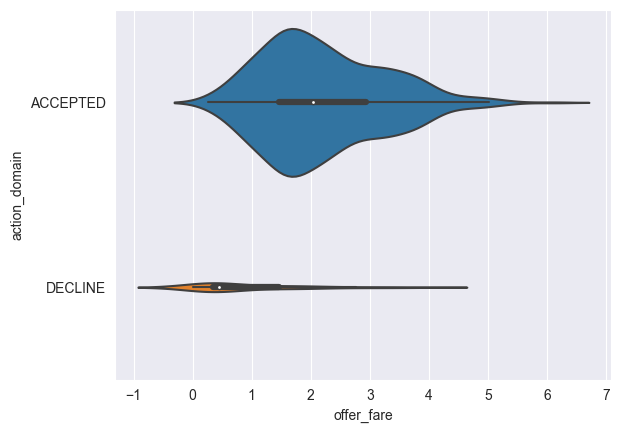

In [7]:
sns.violinplot(
    data=real_offers,
    x="offer_fare", y="action_domain",
    col="is_reposition",
    kind="line", size_order=["T1", "T2"],
    height=5, aspect=.75, facet_kws=dict(sharex=False),
    scale="count"
)

<AxesSubplot: xlabel='offer_travel_time', ylabel='action_domain'>

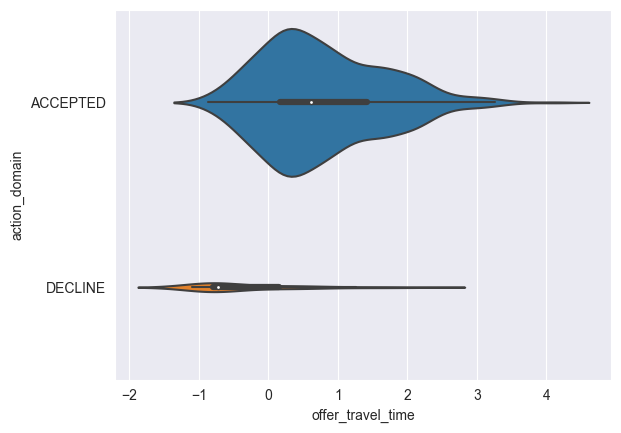

In [8]:
sns.violinplot(
    data=real_offers,
    x="offer_travel_time", y="action_domain",
    col="is_reposition",
    kind="line", size_order=["T1", "T2"],
    height=5, aspect=.75, facet_kws=dict(sharex=False),
    scale="count"
)

<AxesSubplot: xlabel='offer_travel_time', ylabel='offer_fare'>

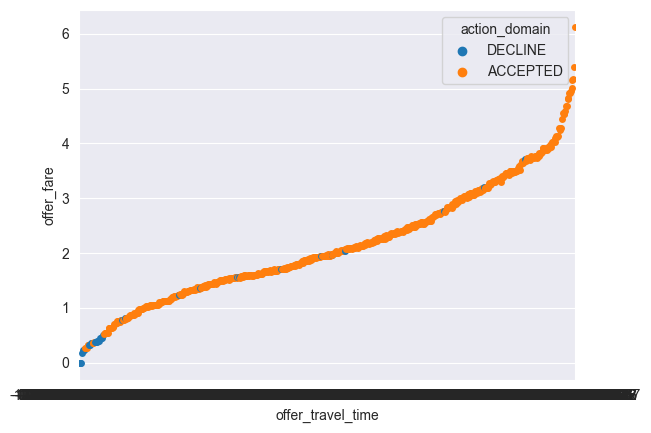

In [9]:
sns.swarmplot(data=real_offers, x="offer_travel_time", y="offer_fare", hue="action_domain")

<AxesSubplot: xlabel='pickup_distance', ylabel='action_domain'>

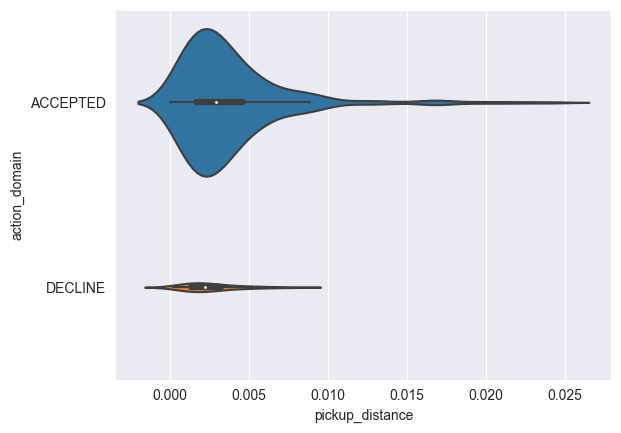

In [10]:
sns.violinplot(
    data=real_offers,
    x="pickup_distance", y="action_domain",
    col="is_reposition",
    kind="line", size_order=["T1", "T2"],
    height=5, aspect=.75, facet_kws=dict(sharex=False),
    scale="count"
)

<AxesSubplot: xlabel='distance_to_target', ylabel='action_domain'>

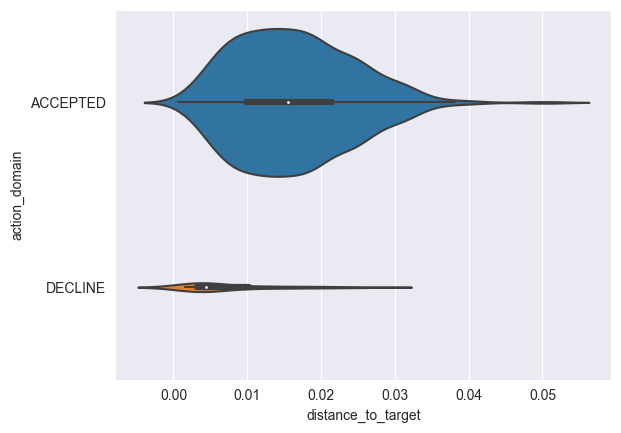

In [11]:
sns.violinplot(
    data=real_offers,
    x="distance_to_target", y="action_domain",
    col="is_reposition",
    kind="line", size_order=["T1", "T2"],
    height=5, aspect=.75, facet_kws=dict(sharex=False),
    scale="count"
)

In [12]:
real_offers.groupby('action_domain')['decision_id'].count() / len(real_offers)

action_domain
ACCEPTED    0.943182
DECLINE     0.056818
Name: decision_id, dtype: float64